# Seismic Travel time Tomography via Fast Marching - Demo on switching regularization and L-curve

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/fmm_tomography/fmm_tomography.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

<!-- TODO - background introduction for this problem. -->

In this notebook, we would like to demonstrate the capability of CoFI to easily
switch between different types of regularizations.

We will use `cofi` to run a seismic tomography example.

## Theoretical background

In [1]:
# display theory on travel time tomography
from IPython.display import display, Markdown

with open("../../theory/geo_travel_time_tomography.md", "r") as f:
    content = f.read()

display(Markdown(content))

The goal in travel-time tomography is to infer details about the velocity structure of a medium, given measurements of the minimum time taken for a wave to propagate from source to receiver. For seismic travel times, as we change our model, the route of the fastest path from source to receiver also changes. This makes the problem nonlinear, as raypaths also depend on the sought after velocity or slowness model. 

Provided the 'true' velocity structure is not *too* dissimilar from our initial guess, travel-time tomography can be treated as a weakly non-linear problem. In this notebook we optionally treat the ray paths as fixed, and so it becomes a linear problem, or calculate rays in the velociuty model.

The travel-time of an individual ray can be computed as $$t = \int_\mathrm{path} \frac{1}{v(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
This points to an additional complication: even for a fixed path, the relationship between velocities and observations is not linear. However, if we define the 'slowness' to be the inverse of velocity, $s(\mathbf{x}) = v^{-1}(\mathbf{x})$, we can write
$$t = \int_\mathrm{path} {s(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
which *is* linear.


We will assume that the object we are interested in is 2-dimensional slowness field. If we discretize this model, with $N_x$ cells in the $x$-direction and $N_y$ cells in the $y$-direction, we can express $s(\mathbf{x})$ as an $N_x \times N_y$ vector $\boldsymbol{s}$. 

**For the linear case**, this is related to the data by
$$d_i = A_{ij}s_j $$
where $d_i$ is the travel time of the ith path, and where $A_{ij}$ represents the path length in cell $j$ of the discretized model.

**For the nonlinear case**, this is related to the data by
$$\delta d_i = A_{ij}\delta s_j $$
where $\delta d_i$ is the difference in travel time, of the ith path, between the observed time and the travel time in the reference model. Here $A_{ij}$ represents the path length in cell $j$ of the discretized model. The parameters $\delta s_j$ are slowness perturbations to the reference model.


For forward modelling, a fast marching wave front tracker is used, utilizing the Fast Marching Fortran code within the package [`FMTOMO`](http://iearth.edu.au/codes/FMTOMO/) by Nick Rawlinson. The Fast Marching code is wrapped in package [pyfm2d](https://github.com/inlab-geo/pyfm2d). Further details can be found in:

- Rawlinson, N., de Kool, M. and Sambridge, M., 2006. Seismic wavefront tracking in 3-D heterogeneous media: applications with multiple data classes, Explor. Geophys., 37, 322-330.
- Rawlinson, N. and Urvoy, M., 2006. Simultaneous inversion of active and passive source datasets for 3-D seismic structure with application to Tasmania, Geophys. Res. Lett., 33 L24313, 10.1029/2006GL028105.
- de Kool, M., Rawlinson, N. and Sambridge, M. 2006. A practical grid based method for tracking multiple refraction and reflection phases in 3D heterogeneous media, Geophys. J. Int., 167, 253-270.
- Saygin, E. 2007. Seismic receiver and noise correlation based studies in Australia, PhD thesis, Australian National University, 10.25911/5d7a2d1296f96.

## 0. Import modules

In [2]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi pyfm2d

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

import cofi
# NB You will need to separately install pyfm2d in your python environment with `pip install pyfm2d'
import pyfm2d as wt # import fmm package 

### Understanding the inference problem

Before we starting working with `cofi`, let's get familiar with the problem itself.

Below is a plot of the true model and the paths generated from this model. As you can see,
there are two anomalies, one with lower velocity (red, top left) and the other with higher
velocity (blue, bottom right).

In [4]:
# read in problem data
loaded_dict = np.load('../../data/travel_time_tomography/nonlinear_tomo_example.npz')
nonlinear_tomo_example = dict(loaded_dict)
loaded_dict.close()

In [5]:
# set up problem
good_model = nonlinear_tomo_example["_mtrue"]
extent = nonlinear_tomo_example["extent"]
sources = nonlinear_tomo_example["sources"]
receivers = nonlinear_tomo_example["receivers"]
obstimes = nonlinear_tomo_example["_data"]
print(' New data set have:\n',len(receivers),' receivers\n',len(sources),' sources\n',len(obstimes),' travel times\n',
'Range of travel times: ',np.min(obstimes),'to',np.max(obstimes),'\n Mean travel time:',np.mean(obstimes))

 New data set have:
 10  receivers
 10  sources
 100  travel times
 Range of travel times:  0.009490006 to 0.01558705 
 Mean travel time: 0.011210016954999999


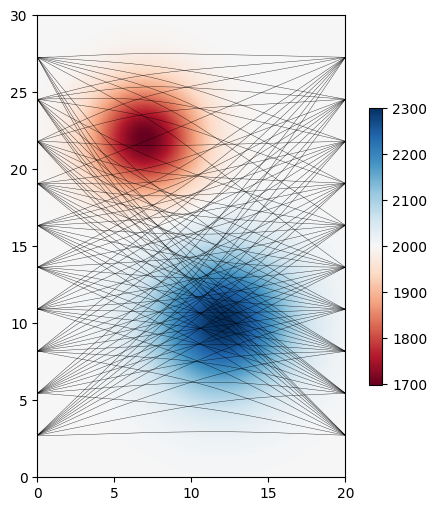

In [6]:
# display true model and raypaths
options = wt.WaveTrackerOptions(paths=True,cartesian=True) # set wavetracker options
result = wt.calc_wavefronts(good_model,receivers,sources,extent=extent, options=options) # track wavefronts
wt.display_model(good_model,paths=result.paths,extent=extent,line=0.3,alpha=0.82)

## 1. Problem setup and utilities

In [7]:
# get problem information 
model_size = good_model.size                           # number of model parameters
model_shape = good_model.shape                         # 2D spatial grid shape
data_size = data_size = len(obstimes)                  # number of data
ref_start_slowness = nonlinear_tomo_example["_sstart"] # use the starting guess supplied by the nonlinear example

In [8]:
def objective_func(slowness, reg, sigma, reduce_data=None):  # reduce_data=(idx_from, idx_to)
    if reduce_data is None: idx_from, idx_to = (0, data_size)
    else: idx_from, idx_to = reduce_data
    if(True):
        options = wt.WaveTrackerOptions(
            cartesian=True,
        )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options) # track wavefronts
        ttimes = result.ttimes
    residual = obstimes[idx_from:idx_to] - ttimes[idx_from:idx_to]
    data_misfit = residual.T @ residual / sigma**2
    model_reg = reg(slowness)
    return  data_misfit + model_reg

def gradient(slowness, reg, sigma, reduce_data=None):       # reduce_data=(idx_from, idx_to)
    if reduce_data is None: idx_from, idx_to = (0, data_size)
    else: idx_from, idx_to = reduce_data
    if(True):
        options = wt.WaveTrackerOptions(
                    paths=True,
                    frechet=True,
                    cartesian=True,
                    )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options) # track wavefronts
        ttimes = result.ttimes
        A = result.frechet.toarray()
    ttimes = ttimes[idx_from:idx_to]
    A = A[idx_from:idx_to]
    data_misfit_grad = -2 * A.T @ (obstimes[idx_from:idx_to] - ttimes) / sigma**2
    model_reg_grad = reg.gradient(slowness)
    return  data_misfit_grad + model_reg_grad

def hessian(slowness, reg, sigma, reduce_data=None):        # reduce_data=(idx_from, idx_to)
    if reduce_data is None: idx_from, idx_to = (0, data_size)
    else: idx_from, idx_to = reduce_data
    if(True):
        options = wt.WaveTrackerOptions(
                    paths=True,
                    frechet=True,
                    cartesian=True,
                    )
        result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options)
        A = result.frechet.toarray()
    A = A[idx_from:idx_to]
    data_misfit_hess = 2 * A.T @ A / sigma**2 
    model_reg_hess = reg.hessian(slowness)
    return data_misfit_hess + model_reg_hess

## 2. Invert with quadratic smoothing and damping regularization terms

### 2.1 Define BaseProblem

In [9]:
# define CoFI BaseProblem
fmm_problem_quadratic_reg = cofi.BaseProblem()
fmm_problem_quadratic_reg.set_initial_model(ref_start_slowness.flatten())

In [10]:
# add regularization: flattening + smoothing
smoothing_factor = 5e6
reg_smoothing = smoothing_factor * cofi.utils.QuadraticReg(
    model_shape=model_shape,
    weighting_matrix="smoothing"
)
reg = reg_smoothing

In [11]:
sigma = 0.000008          # data standard deviation of noise
fmm_problem_quadratic_reg.set_objective(objective_func, args=[reg, sigma, None])
fmm_problem_quadratic_reg.set_gradient(gradient, args=[reg, sigma, None])
fmm_problem_quadratic_reg.set_hessian(hessian, args=[reg, sigma, None])

### 2.2 Define InversionOptions

In [12]:
my_options = cofi.InversionOptions()

my_options.set_tool("cofi.simple_newton")
my_options.set_params(
    num_iterations=15, 
    step_length=1, 
    obj_tol=1e-16,
    verbose=True, 
    hessian_is_symmetric=True
)

### 2.3 Start an inversion

In [13]:
inv = cofi.Inversion(fmm_problem_quadratic_reg, my_options)
inv_result_quadratic_reg = inv.run()
inv_result_quadratic_reg.summary()

Iteration #0, updated objective function value: 2732.686848875463
Iteration #1, updated objective function value: 14.578825308587952
Iteration #2, updated objective function value: 0.8261761272695817
Iteration #3, updated objective function value: 0.09831031157627441
Iteration #4, updated objective function value: 0.048910164044880244
Iteration #5, updated objective function value: 0.04090420334980084
Iteration #6, updated objective function value: 0.0364973320006748
Change in model parameters below tolerance, stopping.
Summary for inversion result
SUCCESS
----------------------------
model: [0.0005026  0.00049998 0.00049576 ... 0.000503   0.00050066 0.00049848]
num_iterations: 6
objective_val: 0.0364973320006748
n_obj_evaluations: 8
n_grad_evaluations: 7
n_hess_evaluations: 7


### 2.4 Plotting

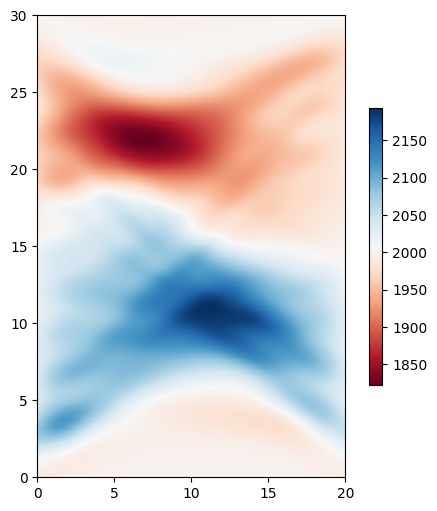

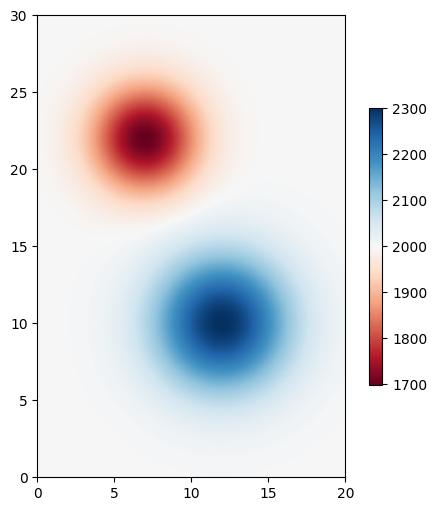

In [14]:
vmodel_inverted = 1./inv_result_quadratic_reg.model.reshape(model_shape)
wt.display_model(vmodel_inverted,extent=extent) # inverted model
wt.display_model(good_model,extent=extent) # true model

---

## 3. Invert with Gaussian prior as regularization term

Instead of using a smoothing and damping regularization, in this section, we
use a model covariance matrix and prior model.

$\chi_{P}^{2}=\left(\mathbf{y} -\mathbf{f}(\mathbf{m})\right)^T C_d^{-1} \left(\mathbf{y} -\mathbf{f}(\mathbf{m})\right) + \left( \mathbf{m} - \mathbf{m}_p \right)^T C_p^{-1} \left( \mathbf{m} - \mathbf{m}_p \right)$

$\Delta \mathbf{m}= ({J}^T {C}_d^{-1} {J}+{C}_p^{-1})^{-1} ({J}^T{C}_d^{-1} (\mathbf{y}-\mathbf{f}(\mathbf{m}))+{C}_p^{-1}(\mathbf{m}_p-\mathbf{m}))$

We can use CoFI's utility module to help us generate a the Gaussian prior term.

### 3.1 Define BaseProblem

In [15]:
# define CoFI BaseProblem
fmm_problem_gaussian_prior = cofi.BaseProblem()
fmm_problem_gaussian_prior.set_initial_model(ref_start_slowness.flatten())

In [16]:
# add regularization: Gaussian prior
corrx = 3.0
corry = 3.0
sigma_slowness = 0.5**2
sigma_slowness = 2.5E-6
gaussian_prior = 0.01 * cofi.utils.GaussianPrior(
    model_covariance_inv=((corrx, corry), sigma_slowness),
    mean_model=ref_start_slowness.reshape(model_shape)
)

In [17]:
fmm_problem_gaussian_prior.set_objective(objective_func, args=[gaussian_prior, sigma])
fmm_problem_gaussian_prior.set_gradient(gradient, args=[gaussian_prior, sigma])
fmm_problem_gaussian_prior.set_hessian(hessian, args=[gaussian_prior, sigma])

### 3.2 Start an inversion

In [18]:
# reuse the previously defined InversionOptions object
inv = cofi.Inversion(fmm_problem_gaussian_prior, my_options)
inv_result_gaussian_prior = inv.run()
inv_result_gaussian_prior.summary()

Iteration #0, updated objective function value: 2110.7661897595167
Iteration #1, updated objective function value: 66.68053886979732
Iteration #2, updated objective function value: 29.02281920239972
Iteration #3, updated objective function value: 25.97700250736072
Iteration #4, updated objective function value: 26.107144045010248
Iteration #5, updated objective function value: 25.98818275353444
Iteration #6, updated objective function value: 26.18476879589477
Iteration #7, updated objective function value: 26.027333445741974
Iteration #8, updated objective function value: 26.245788477751034
Iteration #9, updated objective function value: 26.047889785709078
Iteration #10, updated objective function value: 26.261653152790966
Iteration #11, updated objective function value: 26.054682706712
Iteration #12, updated objective function value: 26.278281562410555
Iteration #13, updated objective function value: 26.05239515476014
Iteration #14, updated objective function value: 26.27794838088067


### 3.3 Plotting

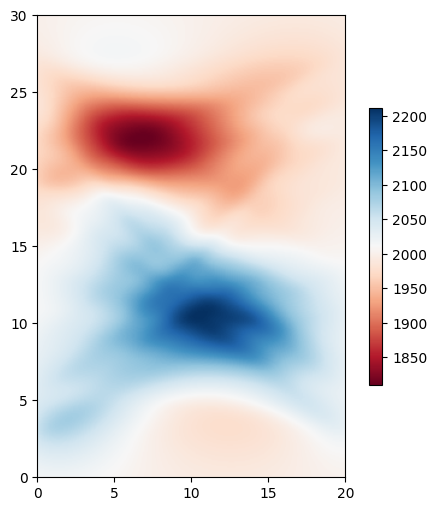

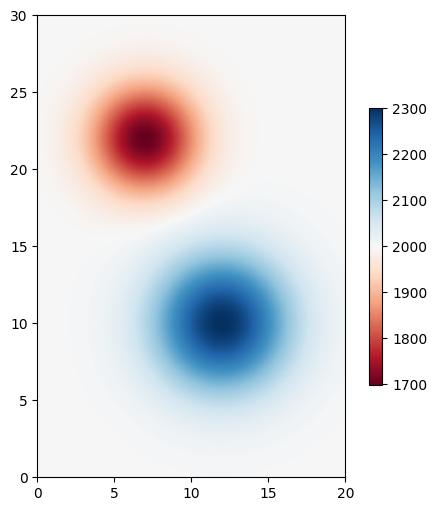

In [19]:
vmodel_inverted = 1./inv_result_gaussian_prior.model.reshape(model_shape)
wt.display_model(vmodel_inverted,extent=extent) # inverted model
wt.display_model(good_model,extent=extent) # true model

## 4. L-curve

Now we plot an L-curve for the smoothing regularization case.

In [20]:
lambdas = np.logspace(-4, 4, 10)

my_lcurve_problems = []
for lamb in lambdas:
    my_reg = lamb * reg_smoothing
    my_problem = cofi.BaseProblem()
    my_problem.set_objective(objective_func, args=[my_reg, sigma])
    my_problem.set_gradient(gradient, args=[my_reg, sigma])
    my_problem.set_hessian(hessian, args=[my_reg, sigma])
    my_problem.set_initial_model(ref_start_slowness.flatten())
    my_lcurve_problems.append(my_problem)

my_options.set_params(verbose=False)

def my_callback(inv_result, i):
    m = inv_result.model
    slowness=m
    options = wt.WaveTrackerOptions(
            cartesian=True,
            )
    result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options) # track wavefronts
    ttimes = result.ttimes
    res_norm = np.linalg.norm(ttimes - obstimes)/sigma**2
    reg_norm = np.sqrt(reg_smoothing(m))
    print(f"Finished inversion with lambda={lambdas[i]}: {res_norm}, {reg_norm}")
    return res_norm, reg_norm

my_inversion_pool = cofi.utils.InversionPool(
    my_lcurve_problems, 
    my_options, 
    my_callback, 
    False
)
all_res, all_cb_returns = my_inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))

Finished inversion with lambda=0.0001: 4919.394126492633, 1.1077215364722592
Finished inversion with lambda=0.000774263682681127: 4909.46037589609, 1.1076783377866393
Finished inversion with lambda=0.005994842503189409: 4905.012822641267, 1.1073607264081824
Finished inversion with lambda=0.046415888336127774: 3094.546606518329, 0.46239540453742045
Finished inversion with lambda=0.3593813663804626: 3876.7767997250508, 0.22905277006603328
Finished inversion with lambda=2.782559402207126: 3830.0064762640905, 0.1586503474664194
Finished inversion with lambda=21.54434690031882: 7347.625825171258, 0.13539627212759858
Finished inversion with lambda=166.81005372000558: 42088.0835753407, 0.12600603895208232
Finished inversion with lambda=1291.5496650148827: 180814.41335016928, 0.1120014790042192
Finished inversion with lambda=10000.0: 492814.67905176064, 0.09598013705590579


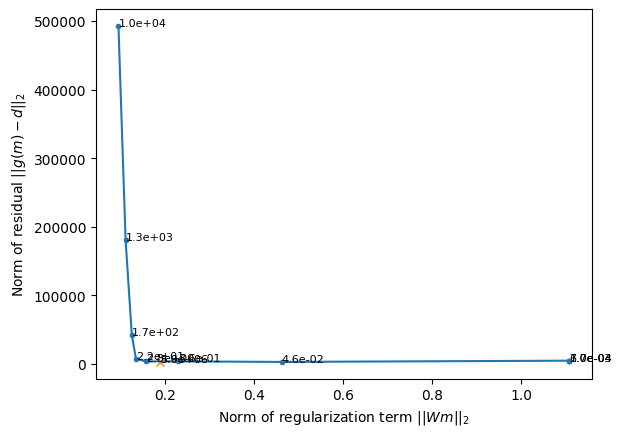

In [21]:
# plot the L-curve
res_norm, reg_norm = l_curve_points
plt.plot(reg_norm, res_norm, '.-')
plt.xlabel(r'Norm of regularization term $||Wm||_2$')
plt.ylabel(r'Norm of residual $||g(m)-d||_2$')
for i in range(len(lambdas)):
    plt.annotate(f'{lambdas[i]:.1e}', (reg_norm[i], res_norm[i]), fontsize=8)

# plot the previously solved model
my_inverted_model = inv_result_quadratic_reg.model
my_reg_norm = np.sqrt(reg_smoothing(my_inverted_model))
slowness=my_inverted_model
options = wt.WaveTrackerOptions(cartesian=True)
result = wt.calc_wavefronts(1./slowness.reshape(model_shape),receivers,sources,extent=extent,options=options) # track wavefronts
ttimes = result.ttimes
my_residual_norm = np.linalg.norm(ttimes - obstimes)/sigma**2
plt.plot(my_reg_norm, my_residual_norm, "x")
plt.annotate(f"{smoothing_factor:.1e}", (my_reg_norm, my_residual_norm), fontsize=8);

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [22]:
watermark_list = ["cofi", "numpy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10
numpy 2.3.5
matplotlib 3.10.7
